In [1]:
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
class Car:
    def __init__(self, position, speed = 1):
        self.speed = speed
        self.position = position
        self.time = 0

    def __int__(self):
        return 3+self.speed


class Grid:
    def __init__(self, TL_change_time = 10):
        self.TL_change_time = TL_change_time

        self.grid = np.full((17,22), -3,dtype=object)
        

        self.grid[5, :] = np.full(22, -1)
        self.grid[11, :] = np.full(22, -1)
        self.grid[:, 5] = np.full(17, -1)
        self.grid[:, 16] = np.full(17, -1)
        
                
                
        # set traffic light (10 for green, -10 for red)
        
        self.time  = 0
        self.grid[4,5] = 10
        self.grid[5,6] = -10
        
        self.grid[6,16] = 10
        self.grid[5,17] = -10
        
        self.grid[10,5] = 10
        self.grid[11,4] = -10
        
        self.grid[12,16] = 10
        self.grid[11,15] = -10
        
 
        
    def update(self):
        self.time += 1
        if self.time % self.TL_change_time == 0:
            # change the traffic light 
            self.grid[4,5] *= -1
            self.grid[5,6] *= -1
            
            self.grid[6,16] *= -1
            self.grid[5,17] *= -1
            
            self.grid[10,5] *= -1
            self.grid[11,4] *= -1
            
            self.grid[12,16] *= -1
            self.grid[11,15] *= -1
    
    def display(self):
        fig, ax = plt.subplots()
        im = ax.imshow(self.grid.astype(int), cmap = plt.cm.RdYlGn)
        plt.title(f'Timestep: {self.time}')
        plt.show()

    def display_animation(self, frames=100, interval=250):
        fig, ax = plt.subplots()
        im = ax.imshow(self.grid.astype(int), cmap = plt.cm.RdYlGn)
        def updatefig(x):
            self.update()
            im.set_array(self.grid.astype(int))
            ax.set_title(f'Timestep: {grid.time}')
            return [im]

        ani = animation.FuncAnimation(fig, updatefig, frames=frames, interval=interval)
        return ani

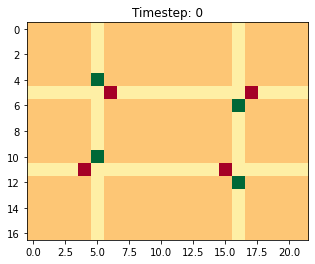

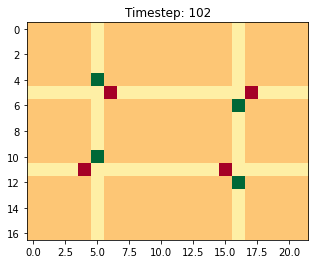

In [3]:
grid = Grid()
grid.display()

ani = grid.display_animation()
HTML(ani.to_html5_video())

In [4]:
class Road:
    def __init__(self, grid, state, TLposition = False, prob_slow = 0.2, 
                 arrival_prob = 0.4, turn_prob = 0.2, connected_road = None):
        self.state = state
        self.grid = grid
        self.road_length = len(state)
        self.TLposition = TLposition
        self.arrival_prob = arrival_prob
        self.turn_prob = turn_prob
        self.prob_slow = prob_slow
        self.time = 0
        self.n_cars = 0
        self.car_time = []
        self.n_car_leaving = 0
    

    def add_car(self):
        if self.state[0] == -1:
            if np.random.uniform() < self.arrival_prob:
                self.state[0] = Car(0)
                self.n_cars += 1
                
            
    def TL_update(self):
        if self.time % grid.TL_change_time == 0:
            for TL in self.TLposition:
                self.state[TL] *= -1
            
    def update(self):
        self.time += 1
        self.TL_update()
        
        next_state = self.state.copy()
        if self.state[-1] != -1:
            self.car_time.append(self.state[-1].time)
            next_state[-1] = -1
            self.n_cars -= 1
            self.n_car_leaving = 1
            
        for i in range(self.road_length-1):
            if self.state[i] != -1 and self.state[i] != -10 and self.state[i] != 10 and np.random.uniform() > self.prob_slow:
                # if the traffic light is green, cross the light
                if self.state[i+1] == 10:
                    next_state[i] = -1
                    next_state[i+2] = self.state[i]
                    next_state[i+2].position = i+2

                # if its empty ahead, go ahead
                elif self.state[i+1] == -1:
                    next_state[i] = -1
                    next_state[i+1] = self.state[i]
                    next_state[i+1].position = i
        
        for i in range(len(self.TLposition)):
            # if the light is red, consider turing to the other road
            pos = self.TLposition[i]
            if self.state[pos] == -10 and self.state[pos-1] != -1 and np.random.uniform() < self.turn_prob:
                new_road, TL = self.connected_road[i]

                # it can only turn if there are no car at the interaction or 
                # behind the green light of the other road
                if new_road.state[new_road.TLposition[TL]+1] == -1 and  new_road.state[new_road.TLposition[TL]-1] == -1:
                    new_road.state[new_road.TLposition[TL]+1] = self.state[pos-1]
                    new_road.state[new_road.TLposition[TL]+1].position = new_road.TLposition[TL]+1
                    self.state[pos-1] = -1
                    self.n_cars -= 1
                    new_road.n_cars += 1
        
        self.state = next_state

        for i in self.state:
            # if it is a car increase its roadtime
            if i != -1 and i != -10 and i != 10:
                i.time += 1
        
        self.add_car()

        self.car_density = self.n_cars/(self.road_length-len(self.TLposition))
        


In [5]:


class TrafficSimulation:
    def __init__(self, max_speed = 5, prob_slow = 0.2, 
                 arrival_prob = 0.4, TL_change_time = 10):
        
        self.TL_change_time = TL_change_time
        self.max_speed = max_speed
        self.arrival_prob = arrival_prob
        self.prob_slow = prob_slow
        self.time = 0 
        
    def initialize(self):
        self.grid = Grid(TL_change_time=self.TL_change_time)
        
        self.road1 = Road(self.grid, self.grid.grid[5,::-1], TLposition = [4, 15], arrival_prob=0.2)
        self.road2 = Road(self.grid, self.grid.grid[11,:], TLposition = [4, 15], arrival_prob=0.2)
        self.road3 = Road(self.grid, self.grid.grid[:, 5], TLposition = [4, 10], arrival_prob=0.2)
        self.road4 = Road(self.grid, self.grid.grid[::-1, 16], TLposition = [4, 10], arrival_prob=0.4)

        self.road1.connected_road = [(self.road4, 1), (self.road3, 0)]
        self.road2.connected_road = [(self.road3, 1), (self.road4, 0)]
        self.road3.connected_road = [(self.road1, 1), (self.road2, 0)]
        self.road4.connected_road = [(self.road2, 1), (self.road1, 0)]
        
    def update(self):
        self.time += 1
        
        self.road1.update()
        self.grid.grid[5,::-1] = self.road1.state
        
        self.road2.update()
        self.grid.grid[11,:] = self.road2.state
        
        self.road3.update()
        self.grid.grid[:, 5] = self.road3.state
        
        self.road4.update()
        self.grid.grid[::-1, 16] = self.road4.state
        
        self.grid.update()

        self.total_car_density = np.mean([self.road1.car_density, self.road2.car_density, 
                                         self.road3.car_density, self.road4.car_density])
        
        self.car_time = self.road1.car_time + self.road2.car_time + self.road3.car_time + self.road4.car_time
                                            
    def display(self):
        self.grid.display()

    def display_animation(self, frames = 100, interval = 250):
        fig, ax = plt.subplots()
        im = ax.imshow(self.grid.grid.astype(int), cmap = plt.cm.RdYlGn)
        def updatefig(x):
            self.update()
            im.set_array(self.grid.grid.astype(int))
            ax.set_title(f'Timestep: {self.grid.time}')
            return [im]

        ani = animation.FuncAnimation(fig, updatefig, frames=frames, interval=interval)
        return ani

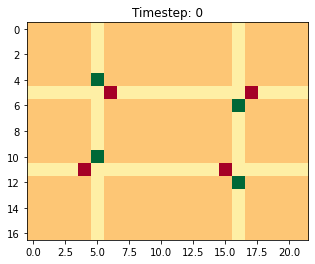

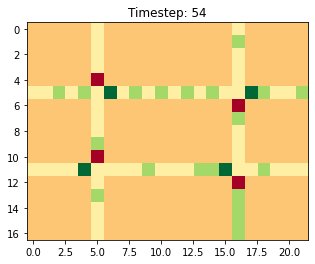

In [35]:
sim = TrafficSimulation()
sim.initialize()
sim.display()

for i in range(54):
    sim.update()
sim.display()

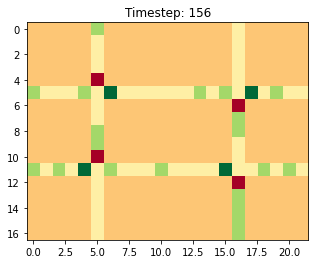

In [36]:
ani = sim.display_animation(frames=100, interval=200)
HTML(ani.to_html5_video())

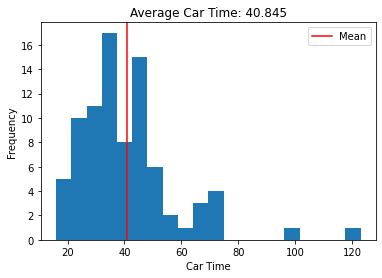

In [41]:
total_car_time = sim.car_time
plt.hist(total_car_time, bins=20)
plt.axvline(np.mean(total_car_time), color = 'r', label = 'Mean')
plt.legend()
plt.xlabel('Car Time')
plt.ylabel('Frequency')
plt.title(f'Average Car Time: {np.mean(total_car_time).round(3)}')
plt.show()

In [9]:
sim = TrafficSimulation()
sim.initialize()

road1_densities = np.zeros(100)
road2_densities = np.zeros(100)
road3_densities = np.zeros(100)
road4_densities = np.zeros(100)
total_densities = np.zeros(100)

trial = 50

for _ in range(trial):
    sim = TrafficSimulation()
    sim.initialize()

    # waiting 100 steps to get an equilibrium system
    for i in range(200):
        sim.update()

    road1_density = np.array([])
    road2_density = np.array([])
    road3_density = np.array([])
    road4_density = np.array([])
    total_density = np.array([])

    for i in range(100):
        sim.update()
        road1_density = np.append(road1_density, sim.road1.car_density)
        road2_density = np.append(road2_density, sim.road2.car_density)
        road3_density = np.append(road3_density, sim.road3.car_density)
        road4_density = np.append(road4_density, sim.road4.car_density)
        total_density = np.append(total_density, sim.total_car_density)

    road1_densities += road1_density 
    road2_densities += road2_density
    road3_densities += road3_density
    road4_densities += road4_density
    total_densities += total_density

road1_densities /= trial
road2_densities /= trial
road3_densities /= trial
road4_densities /= trial
total_densities /= trial
       


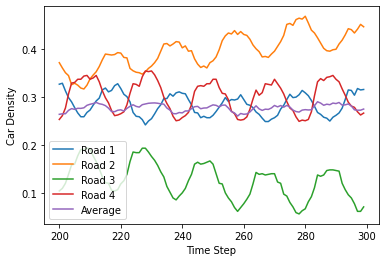

In [10]:
plt.plot(range(200,300), road1_densities, label = 'Road 1')
plt.plot(range(200,300), road2_densities, label = 'Road 2')
plt.plot(range(200,300), road3_densities, label = 'Road 3')
plt.plot(range(200,300), road4_densities, label = 'Road 4')
plt.plot(range(200,300), total_densities, label = 'Average')
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Car Density')
plt.show()

In [11]:
## Modified Version:

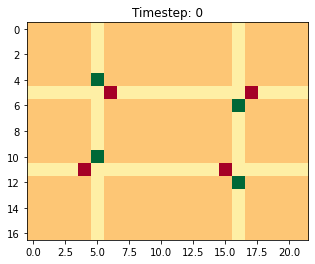

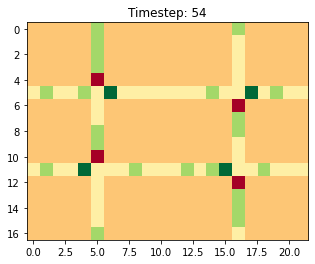

In [38]:
sim2 = TrafficSimulation(TL_change_time=5)
sim2.initialize()
sim2.display()

for i in range(54):
    sim2.update()
sim2.display()

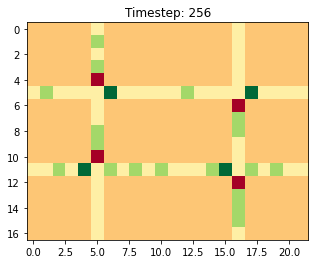

In [39]:
ani = sim2.display_animation(frames=200, interval=150)
HTML(ani.to_html5_video())

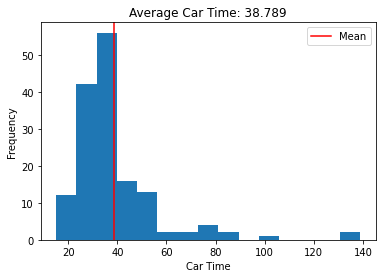

In [40]:
total_car_time = sim2.car_time
plt.hist(total_car_time, bins=15)
plt.axvline(np.mean(total_car_time), color = 'r', label = 'Mean')
plt.legend()
plt.xlabel('Car Time')
plt.ylabel('Frequency')
plt.title(f'Average Car Time: {np.mean(total_car_time).round(3)}')

plt.show()
#print(np.mean(total_car_time))

In [15]:
road1_densities = np.zeros(100)
road2_densities = np.zeros(100)
road3_densities = np.zeros(100)
road4_densities = np.zeros(100)
total_densities = np.zeros(100)

trial = 50

for _ in range(trial):
    sim2 = TrafficSimulation(TL_change_time=5)
    sim2.initialize()

    # waiting 100 steps to get an equilibrium system
    for i in range(200):
        sim2.update()

    road1_density = np.array([])
    road2_density = np.array([])
    road3_density = np.array([])
    road4_density = np.array([])
    total_density = np.array([])

    for i in range(100):
        sim2.update()
        road1_density = np.append(road1_density, sim2.road1.car_density)
        road2_density = np.append(road2_density, sim2.road2.car_density)
        road3_density = np.append(road3_density, sim2.road3.car_density)
        road4_density = np.append(road4_density, sim2.road4.car_density)
        total_density = np.append(total_density, sim2.total_car_density)

    road1_densities += road1_density 
    road2_densities += road2_density
    road3_densities += road3_density
    road4_densities += road4_density
    total_densities += total_density

road1_densities /= trial
road2_densities /= trial
road3_densities /= trial
road4_densities /= trial
total_densities /= trial
       


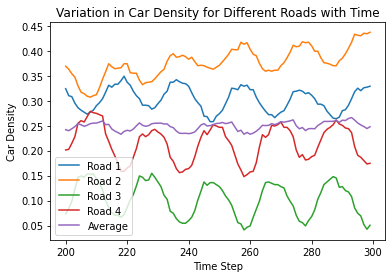

In [16]:
plt.plot(range(200,300), road1_densities, label = 'Road 1')
plt.plot(range(200,300), road2_densities, label = 'Road 2')
plt.plot(range(200,300), road3_densities, label = 'Road 3')
plt.plot(range(200,300), road4_densities, label = 'Road 4')
plt.plot(range(200,300), total_densities, label = 'Average')
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Car Density')
plt.title('Variation in Car Density for Different Roads with Time')
plt.show()

In [17]:
def confidence_interval(data):
    # calculate confidence interval using the formula
    n = len(data)
    m = np.mean(data) # sample mean
    s = np.std(data, ddof = 1) # sample SD
    t = s / np.sqrt(n) # standard error

    return np.array([m - 1.96*t, m + 1.96*t])

In [18]:
cartime_mean = []
cartime_conf_interval = []
cartimes = {}

TL_change_times = np.linspace(2,20,10)

trial = 50

for TL_change_time in TL_change_times:
    cartimes[TL_change_time] = []

    for _ in range(trial):
        sim = TrafficSimulation(TL_change_time=TL_change_time)
        sim.initialize()

        
        for i in range(300):
            sim.update()

        # removing first 100 steps to get an equilibrium system cartime
        cartimes[TL_change_time] += sim.car_time[100:]

        
    cartime_mean.append(np.mean(cartimes[TL_change_time]))
    cartime_conf_interval.append(confidence_interval(cartimes[TL_change_time]))



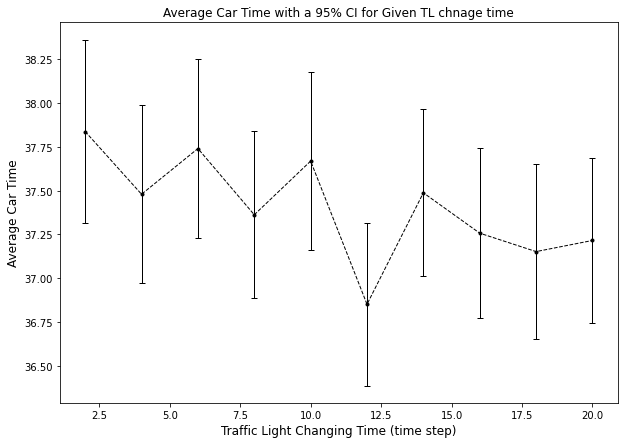

In [19]:
errorbar = np.array(cartime_conf_interval)[:,1] - np.array(cartime_mean)

plt.figure(figsize=(10,7))
plt.errorbar(TL_change_times, cartime_mean, errorbar, 
             color='black', marker='.', capsize = 3, linestyle='--', linewidth=1)
plt.title('Average Car Time with a 95% CI for Given TL chnage time')
plt.xlabel('Traffic Light Changing Time (time step)', fontsize=12)
plt.ylabel('Average Car Time', fontsize=12)
plt.show()

#plt.plot(TL_change_times, total_density_mean, label = 'mean')
#plt.plot(TL_change_times, total_density_75, label = '75% quantile')

## Theoritical Analysis

In [20]:
road4_density_mean = []
road4_density_conf_interval = []
road4_densities = {}

arrival_probs = np.linspace(0.2,1,17)

trial = 50

for arrival_prob in arrival_probs:
    road4_densities[arrival_prob] = np.zeros(100)

    for _ in range(trial):
        sim = TrafficSimulation(TL_change_time=10)
        sim.initialize()
        sim.road4.arrival_prob = arrival_prob

        # waiting 300 steps to get an equilibrium system
        for i in range(300):
            sim.update()

        road4_density = np.array([])

        for i in range(100):
            sim.update()
            road4_density = np.append(road4_density, sim.road4.car_density)

        road4_densities[arrival_prob] += road4_density

    road4_densities[arrival_prob] /= trial
        
    road4_density_mean.append(np.mean(road4_densities[arrival_prob]))
    road4_density_conf_interval.append(confidence_interval(road4_densities[arrival_prob]))



In [21]:
TL_change_time = 10

density_theory = arrival_probs*TL_change_time/sim.road4.road_length
density_theory

array([0.11764706, 0.14705882, 0.17647059, 0.20588235, 0.23529412,
       0.26470588, 0.29411765, 0.32352941, 0.35294118, 0.38235294,
       0.41176471, 0.44117647, 0.47058824, 0.5       , 0.52941176,
       0.55882353, 0.58823529])

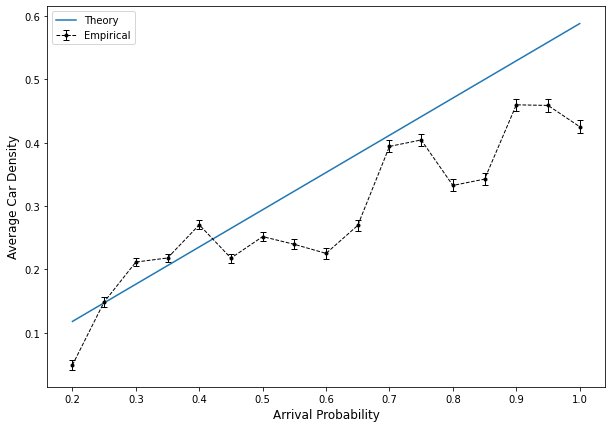

In [22]:
errorbar = np.array(road4_density_conf_interval)[:,1] - np.array(road4_density_mean)

plt.figure(figsize=(10,7))
plt.errorbar(arrival_probs, road4_density_mean, errorbar, 
             color='black', marker='.', capsize = 3, linestyle='--', linewidth=1, label='Empirical')
#plt.title('Expected Maximum Queue Length with a 95% CI for Given Numebr of Cashiers')
plt.plot(arrival_probs, density_theory, label = 'Theory')
plt.xlabel('Arrival Probability', fontsize=12)
plt.ylabel('Average Car Density', fontsize=12)
plt.legend()
plt.show()

#plt.plot(TL_change_times, total_density_mean, label = 'mean')
#plt.plot(TL_change_times, total_density_75, label = '75% quantile')